# Import packages

In [12]:
from src.utils import read_gtf
from scripts.splice_sites_annotation import add_phyloP, gtf_to_SJ
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
ORFanage_ss = pl.read_csv("export/ORFanage_splice_sites.csv")

In [14]:
intronic_seq = read_gtf("nextflow_results/V47/orfanage/orfanage.gtf")\
    .filter(pl.col("feature").is_in(["CDS", "exon"]))\
    .filter(pl.col("seqname")!= "chrM")\
    .pipe(gtf_to_SJ)\
    .unique(["chrom", "strand", "start", "end"])\
    .with_columns(
        coord = pl.int_ranges(pl.col("start") - 1, pl.col("end")).list.sample(2, with_replacement=False)
    )\
    .explode("coord")\
    .with_columns(
        is_novel = pl.lit("intronic"),
        start_or_end = pl.lit("start")
    )\
    .pipe(add_phyloP, "data/cactus241way.phyloP.bw", "mammal")


Text(0.5, 0, 'PhyloP score')

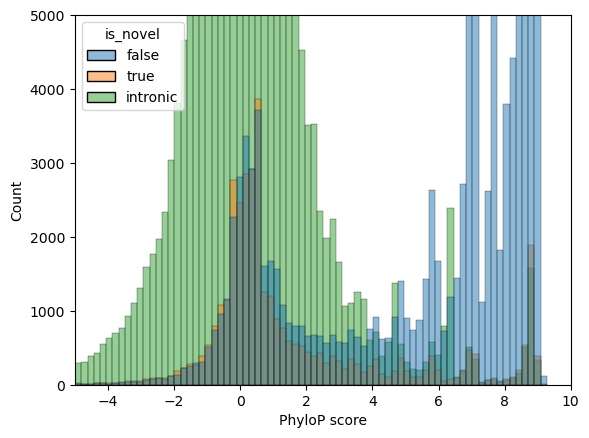

In [18]:
pl.concat([ORFanage_ss.with_columns(pl.col("is_novel").cast(pl.String)), intronic_seq.drop("feature", "start", "end")], how="diagonal")\
    .pipe(sns.histplot, x="mammal_phyloP_1", hue="is_novel")
plt.xlim(-5,10)
plt.ylim(0, 5000)
plt.xlabel("PhyloP score")

# Test export/variant/novel_splice_sites_all.csv

In [3]:
novel_splice_sites_all = pl.read_csv("export/variant/novel_splice_sites_all.csv")
ORFanage_splice_sites = pl.read_csv("export/ORFanage_splice_sites.csv")

In [10]:
novel_splice_sites_all\
    .join(
        ORFanage_splice_sites["chrom", "start", "end", "canonical"],
        on=["chrom", "start", "end"],
        how="left"
    )\
    .filter(
        pl.col("canonical").is_null()
    )

chrom,transcript_id,start_or_end,start,end,canonical
str,str,str,i64,i64,bool
"""chrM""","""PB.112885.4020""","""end""",13995,13996,null
"""chrM""","""PB.112885.366""","""start""",2241,2242,null
"""chrM""","""PB.112885.3879""","""start""",13558,13559,null
"""chrM""","""PB.112885.2563""","""end""",10703,10704,null
"""chrM""","""PB.112885.3568""","""start""",12962,12963,null
…,…,…,…,…,…
"""chrM""","""PB.112885.3676""","""end""",14480,14481,null
"""chrM""","""PB.112885.3913""","""end""",14573,14574,null
"""chrM""","""PB.112885.3519""","""start""",13009,13010,null


The only differences between the two files are the following:
 - `novel_splice_sites_all` contains fewer columns, no strand information
 - `ORFanage_splice_sites` does not contain splice sites in chrM, because phyloP is not available for chrM